In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import sys
import regex as re
import io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import math
import tensorflow as tf
import h5py
import copy
import time
import datetime
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from numpy.linalg import norm
from scipy.spatial.distance import cosine
from scipy.special import softmax
from copy import deepcopy
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, f1_score
import seaborn
from torch.autograd import Variable

LOCAL = True
BASE_DIR = '../'

if not LOCAL:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_DIR = '/content/drive/My Drive/Colab Notebooks/thesis/'

sys.path.append(BASE_DIR + 'lib')
sys.path.append(BASE_DIR + 'config')
from preprocessing import process_sakt, save_h5
import dataset_parameters as params

# DATASET = 'akribian'
# DATASET = 'assistments_2009'
DATASET = 'assistments_2012'
# DATASET = 'junyi_academy'
# DATASET = 'ednet'

TIME_STEPS = params.time_steps_dict[DATASET]

# File paths
IN_DATA_PATH = BASE_DIR + 'data/' + DATASET + '/processed/sakt/' 
INPUT_PATH = IN_DATA_PATH + "processed.h5"
MODEL_PATH = BASE_DIR + 'models/keetar/' 

# Training parameters
BATCH_SIZE = 128
LATENT_DIM = 512 # latent dimension
PADDING = 0
SHUFFLE = True
TIME_STEPS = params.time_steps_dict[DATASET]
#EPOCHS = params.epochs_dict[DATASET]
EPOCHS = 100
NUMBER_OF_EXERCISES = params.exercise_dict[DATASET]
NUMBER_OF_IDS = params.exercise_id_dict[DATASET]
ROWS_PER_READ = 1000000
HEADS_EN = 8
LAYERS_EN = 4
HEADS_DE = 2
LAYERS_DE = 2
WARMUP = 4000
DROPOUT = 0.25

# Use only last query to reduce matmul complexity for long sequences at the cost of performance hit
USE_Q_TRICK = False

# Whether to load relation matrix from file to augment attention weights
USE_RELATION_MATRIX = False
# Whether to preload entire relation matrix into GPU memory
PRELOAD_RELATION_MATRIX = False
# Whether to use time features
USE_ELAPSED = True
USE_TIMESTAMP = False
ZSCORE_ELAPSED = True
# Whether to normalize time features to [0, 1]
NORMALIZE_TIME_FEATURES = False
# Sparsity threshold for relation matrix
THETA = 0.5
# Mixing coefficient for relation matrix
LAMBDA = 0.5
# Whether to concatenate the embeddings instead of adding
CONCATENATE_EMBEDDINGS = True

# How many iterations without improvement to wait before interrupting training
EARLY_STOPPING_TOLERANCE = 3

In [15]:
print("CUDA available: %i" % torch.cuda.is_available())
cuda = torch.device("cuda:0")
torch.set_default_tensor_type('torch.cuda.FloatTensor')

CUDA available: 1


# Model class

In [16]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

    def zero_grad(self):
        self.optimizer.zero_grad()
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

## Multihead attention

In [17]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #pe = pe.unsqueeze(0)
        #print(pe.shape)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

def attention(query, key, value, mask=None, dropout=None, relation_matrix = None, q_trick = False):
    "Compute 'Scaled Dot Product Attention'"
    # Data is in the format (b,h,n,d_k)
    d_k = key.size(-1)
    n = key.size(-2)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
                / math.sqrt(d_k)
    # scores is in the shape (b, h, n, n)
    # mask is in the shape (b, h, n, n)
    if relation_matrix is not None:
        scores = LAMBDA * scores + (1 - LAMBDA) * relation_matrix
        # scores = (relation_matrix + LAMBDA) * scores
    if mask is not None:
        scores.masked_fill_(~mask, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiheadAttention(nn.Module):
    def __init__(self, number_of_heads, dim_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiheadAttention, self).__init__()
        assert dim_model % number_of_heads == 0
        # We assume d_v always equals d_k
        self.d_k = dim_model // number_of_heads
        self.h = number_of_heads
        self.linears = nn.ModuleList([nn.Linear(dim_model, dim_model) for _ in range(4)])
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None, padding_mask=None, relation_matrix=None, q_trick = False):

        "Implements Figure 2"
        # if mask is not None:
        #     # Same mask applied to all h heads.
        #     mask = mask.unsqueeze(1)
        nbatches = key.size(0)
        seq_len = key.size(1)
        
        # right now the data is in the shape (b,n,d_model)
        # 1) Do all the linear projections in batch from d_model => h x d_k and then transposed to swap dim of h and n
        # q,k,v will each have shape (b, h, n, d_k)
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        # mask has shape (n, n)
        if not USE_Q_TRICK:
            mask = mask.unsqueeze(0).unsqueeze(0).repeat(nbatches, self.h, 1, 1) # (n,n) -> (b,h,n,n)
        # padding mask has shape (b, n)
        padding_mask = padding_mask.unsqueeze(1).unsqueeze(1).repeat(1, self.h, 1, 1) # (b,n) -> (b,h,n,n)
        # data has shape (b, h, n, d_k)
        x, self.attn = attention(query, key, value,                       
                                 mask=padding_mask if q_trick else mask * padding_mask,
                                 dropout=self.dropout,
                                 relation_matrix=relation_matrix,
                                 q_trick = q_trick)

        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

class Feed_Forward_block(nn.Module):
    """
    out =  Relu( M_out*w1 + b1) *w2 + b2
    """
    def __init__(self, dim_ff):
        super().__init__()
        self.layer1 = nn.Linear(in_features=dim_ff , out_features=dim_ff)
        self.layer2 = nn.Linear(in_features=dim_ff , out_features=dim_ff)

    def forward(self,ffn_in):
        return  self.layer2(   F.relu( self.layer1(ffn_in) )   )
        

class Encoder_block(nn.Module):
    """
    M = SkipConct(Multihead(LayerNorm(Qin;Kin;Vin)))
    O = SkipConct(FFN(LayerNorm(M)))
    """

    def __init__(self , dim_model, heads_en, total_ex ,total_cat, seq_len, dropout):
        super().__init__()
        self.seq_len = seq_len
        
        self.multi_en = MultiheadAttention( number_of_heads = heads_en, dim_model = dim_model, dropout = dropout  )     # multihead attention ## todo add dropout, LayerNORM
        self.ffn_en = Feed_Forward_block( dim_model )                                            # feedforward block   ## todo dropout, LayerNorm
        self.layer_norm1 = nn.LayerNorm( dim_model )
        self.layer_norm2 = nn.LayerNorm( dim_model )
        self.dropout = nn.Dropout(p=dropout)


    def forward(self, in_ex, relation_matrix = None, padding_mask = None, q_trick = False):

        # input is batch-first (b,n,d)
        out = in_ex                                      # Applying positional embedding

        # out = out.permute(1,0,2)                         # -> (n,b,d)

        # index for last query
        if (q_trick):
            last_indices = torch.count_nonzero(padding_mask, 1) - 1 
            last_indices = last_indices.unsqueeze(1).unsqueeze(1).repeat(1, 1, out.size(2))
            query = out.gather(1, last_indices.cuda())
        else:
            query = out

        #Multihead attention                            
        b,n,d = out.shape
        out = self.layer_norm1( out )                           # Layer norm
        skip_out = out
        # attention function accepts batch-first format
        out = self.multi_en( query , out , out ,
                                mask=subsequent_mask(n)
                                ,padding_mask = padding_mask 
                                ,relation_matrix = relation_matrix
                                ,q_trick = q_trick
                                )  # attention mask upper triangular
        out = out + skip_out                                    # skip connection
        out = self.dropout(out)

        #feed forward
        # out = out.permute(1,0,2)                                # -> (b,n,d)
        out = self.layer_norm2( out )                           # Layer norm 
        skip_out = out
        out = self.ffn_en( out )
        out = out + skip_out                                    # skip connection
        out = self.dropout(out)

        return out

class Decoder_block(nn.Module):
    """
    M1 = SkipConct(Multihead(LayerNorm(Qin;Kin;Vin)))
    M2 = SkipConct(Multihead(LayerNorm(M1;O;O)))
    L = SkipConct(FFN(LayerNorm(M2)))
    """

    def __init__(self,dim_model ,total_in, heads_de,seq_len, dropout  ):
        super().__init__()
        self.seq_len    = seq_len
        self.embd_in    = nn.Embedding(  total_in , embedding_dim = dim_model )                  #interaction embedding
        self.embd_pos   = nn.Embedding(  seq_len , embedding_dim = dim_model )                  #positional embedding
        #self.embd_pos   = PositionalEncoding(  dim_model, 0., seq_len )
        self.multi_de1  = nn.MultiheadAttention( embed_dim= dim_model, num_heads= heads_de  )  # M1 multihead for interaction embedding as q k v
        self.multi_de2  = nn.MultiheadAttention( embed_dim= dim_model, num_heads= heads_de  )  # M2 multihead for M1 out, encoder out, encoder out as q k v
        self.ffn_en     = Feed_Forward_block( dim_model )                                         # feed forward layer

        self.layer_norm1 = nn.LayerNorm( dim_model )
        self.layer_norm2 = nn.LayerNorm( dim_model )
        self.layer_norm3 = nn.LayerNorm( dim_model )
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, in_in, en_out,first_block=True):

         ## todo create a positional encoding ( two options numeric, sine)
        if first_block:
            in_in = self.embd_in( in_in )

            #combining the embedings
            out = in_in                         # (b,n,d)
        else:
            out = in_in

        in_pos = get_pos(self.seq_len)
        in_pos = self.embd_pos( in_pos )
        out = out + in_pos                                          # Applying positional embedding

        out = out.permute(1,0,2)                                    # (n,b,d)# print('pre multi', out.shape )
        n,_,_ = out.shape

        #Multihead attention M1                                     ## todo verify if E to passed as q,k,v
        out = self.layer_norm1( out )
        skip_out = out
        out, attn_wt = self.multi_de1( out , out , out, 
                                     attn_mask=get_mask(seq_len=n)) # attention mask upper triangular
        out = skip_out + out                                        # skip connection
        out = self.dropout(out)

        #Multihead attention M2                                     ## todo verify if E to passed as q,k,v
        en_out = en_out.permute(1,0,2)                              # (b,n,d)-->(n,b,d)
        en_out = self.layer_norm2( en_out )
        skip_out = out
        out, attn_wt = self.multi_de2( out , en_out , en_out,
                                    attn_mask=get_mask(seq_len=n))  # attention mask upper triangular
        out = out + skip_out
        out = self.dropout(out)

        #feed forward
        out = out.permute(1,0,2)                                    # (b,n,d)
        out = self.layer_norm3( out )                               # Layer norm 
        skip_out = out
        out = self.ffn_en( out )                                    
        out = out + skip_out                                        # skip connection
        out = self.dropout(out)


        return out

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


def get_mask(seq_len):
    ##todo add this to device
    return torch.from_numpy( np.triu(np.ones((seq_len ,seq_len)), k=1).astype('bool')).cuda()

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (size, size)
    subsequent_mask = np.tril(np.ones(attn_shape), k=0).astype('uint8')
    return torch.from_numpy(subsequent_mask).cuda() == 1

def get_pos(seq_len):
    # use sine positional embeddinds
    return torch.arange( seq_len ).unsqueeze(0)
    #return torch.arange( seq_len ).unsqueeze(1)



## SAINT

In [18]:
class saint(nn.Module):
    def __init__(self,dim_model,num_en, num_de ,heads_en, total_ex ,total_cat, total_in, heads_de, seq_len, dropout ):
        super().__init__( )

        self.embd_ex =   nn.Embedding( total_ex, embedding_dim = dim_model ) # embedings  q,k,v = E = exercise ID embedding, category embedding, and positionembedding.
        self.embd_cat =  nn.Embedding( total_cat, embedding_dim = dim_model )
        self.embd_correct = nn.Embedding( total_in, embedding_dim = dim_model )
        self.embd_pos   = nn.Embedding(  seq_len , embedding_dim = dim_model ) # positional embedding

        self.num_en = num_en
        self.num_de = num_de

        self.encoder = get_clones(Encoder_block(dim_model, heads_en, total_ex, total_cat, seq_len, dropout), num_en)
        self.decoder = get_clones(Decoder_block(dim_model ,total_in, heads_de, seq_len, dropout)           , num_de)

        self.out = nn.Linear(in_features= dim_model , out_features=1)
    
    def forward(self, in_ex, in_cat, in_in, in_elapsed=None, in_ts=None, relation_matrix=None ):
        
        padding_mask = in_ex > 0  # (b,n). pytorch wants it in this format
        padding_mask = padding_mask.cuda()

        n_batch = in_ex.size(0)

        in_ex_np = in_ex.cpu().detach().numpy()

        if relation_matrix is not None:
            # first select the rows that we need
            if PRELOAD_RELATION_MATRIX:
                relation_matrix_slice = relation_matrix[in_ex_np,:]
            else:                
                relation_matrix_slice = torch.from_numpy(relation_matrix[in_ex_np,:]).cuda()
            # then select the columns that we need
            relation_matrix_slice = relation_matrix_slice[:,:,in_ex.long()]
            # now we have useless rows, we have to select the right row from each of the batch 'mini-matrices'
            relation_matrix_slice = relation_matrix_slice[torch.arange(n_batch),:,torch.arange(n_batch),:]
            # if we're doing q-trick we have to select only the row corresponding to the query
            if (self.q_trick):
                # indices for the query rows
                last_indices = (torch.count_nonzero(padding_mask, 1) - 1).cuda()
                # select rows according to indices
                relation_matrix_slice = relation_matrix_slice[torch.arange(n_batch), last_indices, :]
                # unsqueeze so shape is consistent with scores
                relation_matrix_slice = relation_matrix_slice.unsqueeze(1)
            # create 'heads' dimension for the relation matrix slice so it's the same shape as scores matrix in attention function
            relation_matrix_slice = relation_matrix_slice.unsqueeze(1).repeat(1, self.h, 1, 1).float()
        else:
            relation_matrix_slice = None


        #combining the embedings
        in_ex = self.embd_ex( in_ex )
        in_cat = self.embd_cat( in_cat )
        in_in = self.embd_correct( in_in )

        in_pos = get_pos(self.seq_len)
        in_pos = self.embd_pos( in_pos )

        if CONCATENATE_EMBEDDINGS:
            in_pos = in_pos.repeat(in_ex.size(0), 1, 1)
            in_ex = torch.cat((in_ex, in_cat, in_in, in_pos), 2)
        else:
            in_ex = in_ex + in_cat + in_in + in_pos # (b,n,d)

        if self.use_time_features:
            in_elapsed = self.embed_vector_elapsed(in_elapsed)
            in_ts = self.embed_vector_timestamp(in_ts)
            if CONCATENATE_EMBEDDINGS:
                in_ex = torch.cat((in_ex, in_elapsed, in_ts), 2)
            else:
                in_ex = in_ex + in_elapsed + in_ts
            


        ## pass through each of the encoder blocks in sequence
        for x in range(self.num_en):
            in_ex = self.encoder[x]( in_ex, relation_matrix = relation_matrix_slice, padding_mask = padding_mask)
                    
        for x in range(self.num_de):
            in_in = self.decoder[x]( in_in, in_ex, relation_matrix = relation_matrix_slice, padding_mask = padding_mask)

        ## Output layer
        in_in = torch.sigmoid( self.out( in_in ) )
        return in_in

## KEETAR

In [19]:
class keetar(nn.Module):
    def __init__(self, dim_model, num_en, heads_en, total_ex ,total_cat, total_in, seq_len, dropout, q_trick = False):
        super().__init__( )

        self.num_en = num_en
        self.seq_len = seq_len
        self.h = heads_en
        self.q_trick = q_trick

        self.embd_ex =   nn.Embedding( total_ex, embedding_dim = dim_model ) # embedings  q,k,v = E = exercise ID embedding, category embedding, and positionembedding.
        self.embd_cat =  nn.Embedding( total_cat, embedding_dim = dim_model )
        self.embd_correct = nn.Embedding( total_in, embedding_dim = dim_model )
        self.embd_pos   = nn.Embedding(  seq_len , embedding_dim = dim_model ) # positional embedding

        self.embed_vector_elapsed = nn.Linear(1, dim_model)
        self.embed_vector_timestamp = nn.Linear(1, dim_model)        
        
        if CONCATENATE_EMBEDDINGS:
            self.in_ffn = nn.Linear((4 + 1 * USE_ELAPSED + 1 * USE_TIMESTAMP) * dim_model, dim_model)
        else:
            self.in_ffn = nn.Linear(dim_model, dim_model)

        self.encoder = get_clones(Encoder_block(dim_model, heads_en, total_ex, total_cat, seq_len, dropout), num_en)
        self.lstm = nn.LSTM(dim_model, dim_model, 1, dropout = dropout, batch_first=True)
        self.out_ffn = nn.Linear(dim_model, 3)
        self.softmax = nn.Softmax(2)

        self.relu = nn.ReLU()

        self.layer_norm = nn.LayerNorm( dim_model )

        self.dout = nn.Dropout(dropout)
    
    def forward(self, in_ex, in_cat, in_in, in_elapsed=None, in_ts=None, relation_matrix=None ):

        padding_mask = in_ex > 0  # (b,n). pytorch wants it in this format
        padding_mask = padding_mask.cuda()

        n_batch = in_ex.size(0)

        in_ex_np = in_ex.cpu().detach().numpy()

        if relation_matrix is not None:
            # first select the rows that we need
            if PRELOAD_RELATION_MATRIX:
                relation_matrix_slice = relation_matrix[in_ex_np,:]
            else:                
                relation_matrix_slice = torch.from_numpy(relation_matrix[in_ex_np,:]).cuda()
            # then select the columns that we need
            relation_matrix_slice = relation_matrix_slice[:,:,in_ex.long()]
            # now we have useless rows, we have to select the right row from each of the batch 'mini-matrices'
            relation_matrix_slice = relation_matrix_slice[torch.arange(n_batch),:,torch.arange(n_batch),:]
            # if we're doing q-trick we have to select only the row corresponding to the query
            if (self.q_trick):
                # indices for the query rows
                last_indices = (torch.count_nonzero(padding_mask, 1) - 1).cuda()
                # select rows according to indices
                relation_matrix_slice = relation_matrix_slice[torch.arange(n_batch), last_indices, :]
                # unsqueeze so shape is consistent with scores
                relation_matrix_slice = relation_matrix_slice.unsqueeze(1)
            # create 'heads' dimension for the relation matrix slice so it's the same shape as scores matrix in attention function
            relation_matrix_slice = relation_matrix_slice.unsqueeze(1).repeat(1, self.h, 1, 1).float()
        else:
            relation_matrix_slice = None


        #combining the embedings
        in_ex = self.embd_ex( in_ex )
        in_cat = self.embd_cat( in_cat )
        in_in = self.embd_correct( in_in )

        in_pos = get_pos(self.seq_len)
        in_pos = self.embd_pos( in_pos )

        if CONCATENATE_EMBEDDINGS:
            in_pos = in_pos.repeat(in_ex.size(0), 1, 1)
            in_ex = torch.cat((in_ex, in_cat, in_in, in_pos), 2)
        else:
            in_ex = in_ex + in_cat + in_in + in_pos # (b,n,d)

        if USE_ELAPSED:
            in_elapsed = self.embed_vector_elapsed(in_elapsed)
            if CONCATENATE_EMBEDDINGS:
                # in_ex = torch.cat((in_ex, in_elapsed, in_ts), 2)
                in_ex = torch.cat((in_ex, in_elapsed), 2)
            else:
                in_ex = in_ex + in_elapsed

        if USE_TIMESTAMP:
            in_ts = self.embed_vector_timestamp(in_ts)
            if CONCATENATE_EMBEDDINGS:
                in_ex = torch.cat((in_ex, in_ts), 2)
            else:
                in_ex = in_ex + in_ts
            

        in_ex = self.in_ffn(in_ex)

        in_ex = self.relu(in_ex)
        
        ## Pass through each of the encoder blocks in sequence
        # input (b,n,d); output (b,n,d)
        for x in range(self.num_en):
            in_ex = self.encoder[x]( in_ex, relation_matrix = relation_matrix_slice, padding_mask = padding_mask, q_trick = self.q_trick)

        in_ex = self.dout(in_ex)

        ## Pass through LSTM
        res = in_ex
        in_ex, _ = self.lstm(in_ex)
        in_ex = in_ex + res

        # Layer norm
        in_ex = self.layer_norm(in_ex)
        ## Pass through final FFN
        in_ex = self.out_ffn(in_ex)
        
        ## Softmax and output
        in_ex = self.softmax(in_ex)
        return in_ex

# Model training

In [20]:
model = keetar(dim_model=LATENT_DIM,
            seq_len=TIME_STEPS,
            num_en=LAYERS_EN,
            heads_en=HEADS_EN,
            total_ex= NUMBER_OF_IDS,
            total_cat= NUMBER_OF_EXERCISES,
            total_in= 3,
            dropout = DROPOUT,
            q_trick = USE_Q_TRICK).cuda()

criterion = nn.CrossEntropyLoss()
#optimizer = NoamOpt(LATENT_DIM, 1, WARMUP, optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8))
#optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=WEIGHT_DECAY)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-8)

In [21]:
if USE_RELATION_MATRIX:
    relation_matrix = np.load(IN_DATA_PATH + 'relation_matrix.npy')
    relation_matrix[relation_matrix < THETA] = 0.
    if PRELOAD_RELATION_MATRIX:
        relation_matrix = torch.from_numpy(relation_matrix).cuda()
else:
    relation_matrix = None

In [22]:
## Training the model
print_freq = 10
graph_freq = 10

losses_history = []

val_accs = []

previous_acc = 0.0

no_improvement_streak = 0
best_acc = 0.0

h5_file = h5py.File(INPUT_PATH,'r')

# labels_val = torch.from_numpy(h5_file['labels_val'][:]).flatten()

number_of_train_windows = h5_file['exercises_train'].shape[0]
number_of_val_windows = h5_file['exercises_val'].shape[0]

actual_epochs = 0
training_start_time = time.time()

for epoch in range(EPOCHS):
  epoch_start_time = time.time()
  actual_epochs += 1

  print("Epoch %i" % (epoch+1))
  total_loss_print = 0.0
  total_loss_graph = 0.0

  for read_index in range(0, number_of_train_windows, ROWS_PER_READ):

    exercises_train = h5_file['exercises_train'][read_index:read_index+ROWS_PER_READ]
    exercise_ids_train = h5_file['exercise_ids_train'][read_index:read_index+ROWS_PER_READ]
    labels_train = h5_file['labels_train'][read_index:read_index+ROWS_PER_READ]
    past_labels_train = h5_file['past_labels_train'][read_index:read_index+ROWS_PER_READ]
    elapsed_train = h5_file['elapsed_train'][read_index:read_index+ROWS_PER_READ]
    timestamp_train = h5_file['timestamps_train'][read_index:read_index+ROWS_PER_READ]
    past_zscore_train = h5_file['past_elapsed_zscore_train'][read_index:read_index+ROWS_PER_READ]
    latency_train = h5_file['current_latency_train'][read_index:read_index+ROWS_PER_READ]
    past_latency_train = h5_file['past_latency_train'][read_index:read_index+ROWS_PER_READ]

    if SHUFFLE:
      random_indices = np.arange(len(exercises_train))
      np.random.shuffle(random_indices)
      exercises_train = exercises_train[random_indices]
      exercise_ids_train = exercise_ids_train[random_indices]
      labels_train = labels_train[random_indices]
      past_labels_train = past_labels_train[random_indices]
      elapsed_train = elapsed_train[random_indices]
      timestamp_train = timestamp_train[random_indices]
      past_zscore_train = past_zscore_train[random_indices]
      latency_train = latency_train[random_indices]
      past_latency_train = past_latency_train[random_indices]

    for idx in range(0, len(exercises_train), BATCH_SIZE):
      # Retrieve data
      cat_samples = torch.from_numpy(exercises_train[idx:idx + BATCH_SIZE]).long().cuda()
      id_samples = torch.from_numpy(exercise_ids_train[idx:idx + BATCH_SIZE]).long().cuda()
      label = torch.from_numpy(labels_train[idx:idx + BATCH_SIZE]).unsqueeze(2).long().cuda()
      shifted_label = torch.from_numpy(past_labels_train[idx:idx + BATCH_SIZE]).long().cuda()
      elapsed = torch.from_numpy(elapsed_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
      timestamp = torch.from_numpy(timestamp_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
      past_zscore = torch.from_numpy(past_zscore_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
      latency = torch.from_numpy(latency_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
      past_latency = torch.from_numpy(past_latency_train[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()

      if NORMALIZE_TIME_FEATURES:
        elapsed /= 300.
        timestamp /= 1440.

      # Reset optimizer
      optimizer.zero_grad()

      # Predict
      out = model(id_samples, cat_samples, shifted_label, past_zscore if ZSCORE_ELAPSED else elapsed, timestamp, relation_matrix)

      if torch.isnan(out).any():
        print("Model output contains nan")
        bad_index = torch.isnan(out.squeeze())
        print("Offending input:")
        print("ID: ")
        print(id_samples[bad_index])
        print("Category: ")
        print(cat_samples[bad_index])
        raise Exception("Model output contains nan")

      # print("output:")
      # print(out.shape)
      # print(out)

      # Calculate loss 
      loss = criterion(out.view(-1, 3), latency.view(-1).long())
      total_loss_print += loss.item()
      total_loss_graph += loss.item()

      # Optimize
      loss.backward()
      optimizer.step()

      idx_discrete = int(idx / BATCH_SIZE)

      # Print status
      if (idx_discrete % print_freq == print_freq - 1):
        avg_loss = total_loss_print/print_freq
        sys.stdout.write("\rTraining %i/%i, avg loss %.5f, %s" % (idx+1, number_of_train_windows, avg_loss, str(datetime.timedelta(seconds=int(time.time() - epoch_start_time))) ))
        sys.stdout.flush()
        total_loss_print = 0.0

      # Append to graph
      if (idx_discrete % graph_freq == graph_freq - 1):
        avg_loss = total_loss_graph/graph_freq
        losses_history.append(avg_loss)
        total_loss_graph = 0.0
          
  # Validation step
  # Set evaluation mode
  outs_preds = np.array([])
  val_labels_last = np.array([])
  model.eval()
  val_start_time = time.time()
  print()
  # Turn off grad calculation
  with torch.no_grad():
    # Iterate through val data
    for read_index in range(0, number_of_val_windows, ROWS_PER_READ):
      exercises_val = h5_file['exercises_val'][read_index:read_index+ROWS_PER_READ]    
      exercise_ids_val = h5_file['exercise_ids_val'][read_index:read_index+ROWS_PER_READ]
      labels_val = h5_file['labels_val'][read_index:read_index+ROWS_PER_READ]
      past_labels_val = h5_file['past_labels_val'][read_index:read_index+ROWS_PER_READ]
      elapsed_val = h5_file['elapsed_val'][read_index:read_index+ROWS_PER_READ]
      timestamp_val = h5_file['timestamps_val'][read_index:read_index+ROWS_PER_READ]
      past_zscore_val = h5_file['past_elapsed_zscore_val'][read_index:read_index+ROWS_PER_READ]
      latency_val = h5_file['current_latency_val'][read_index:read_index+ROWS_PER_READ]
      past_latency_val = h5_file['past_latency_val'][read_index:read_index+ROWS_PER_READ]


      for idx in range(0, len(exercises_val), BATCH_SIZE):

        # Print status
        idx_discrete = int(idx / BATCH_SIZE)
        if (idx_discrete % print_freq == print_freq - 1):
          sys.stdout.write("\rEvaluating %i/%i, %s" % (idx+1, number_of_val_windows, str(datetime.timedelta(seconds=int(time.time() - val_start_time))) ))
          sys.stdout.flush()

        cat_samples_val = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]).long().cuda()
        id_samples_val = torch.from_numpy(exercise_ids_val[idx:idx + BATCH_SIZE]).long().cuda()
        label = labels_val[idx:idx + BATCH_SIZE]
        shifted_label_val = torch.from_numpy(past_labels_val[idx:idx + BATCH_SIZE]).long().cuda()
        elapsed = torch.from_numpy(elapsed_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
        timestamp = torch.from_numpy(timestamp_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
        past_zscore = torch.from_numpy(past_zscore_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()        
        latency = latency_val[idx:idx + BATCH_SIZE]
        past_latency = torch.from_numpy(past_latency_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()

        outs_pred = model(id_samples_val, cat_samples_val, shifted_label_val, past_zscore if ZSCORE_ELAPSED else elapsed, timestamp, relation_matrix)        

        if USE_Q_TRICK:
          ## method 2: slice only the last non-padding element
          last_indices = torch.count_nonzero(torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]), 1) - 1
          outs_pred_indexed = outs_pred.squeeze().gather(1, last_indices.view(-1,1).cuda()).cpu().detach().numpy()
          label_indexed = torch.from_numpy(label).gather(1, last_indices.view(-1,1)).cpu().detach().numpy()
        else:
          ## method 1: slice entire sequence
          padding_mask = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]) != 0      
          outs_argmax = torch.argmax(outs_pred, 2)
          outs_pred_np = outs_argmax.cpu().detach().numpy()
          outs_pred_indexed = outs_pred_np[padding_mask]
          label_indexed = latency[padding_mask]

        val_labels_last = np.append(val_labels_last, label_indexed)
        outs_preds = np.append(outs_preds, outs_pred_indexed)

  # Revert to training mode
  model.train()

  # labels_val = h5_file['labels_val'][:].flatten()
  acc_score = accuracy_score(val_labels_last, outs_preds)
  # acc_score = roc_acc_score(val_labels_last, outs_preds)
  val_accs.append(acc_score)
  print("\nValidation accuracy: %f" % acc_score)
  print("Validation F1: %f" % f1_score(val_labels_last, outs_preds, average='weighted'))
  acc_diff = acc_score - previous_acc
  if epoch != 0:
    print("Accuracy difference: %f" % acc_diff)

  if acc_score < best_acc:
    no_improvement_streak += 1
  else:
    no_improvement_streak = 0
    best_acc = acc_score
    torch.save(model.state_dict(), MODEL_PATH + DATASET + ".torch")
    print("Model saved")

  if no_improvement_streak >= EARLY_STOPPING_TOLERANCE:
    break

  previous_acc = acc_score

print("%i epochs completed in %s" % (actual_epochs, str(datetime.timedelta(seconds=int(time.time() - training_start_time)))))

model.eval()

outs_preds = np.array([])
val_labels_last = np.array([])
val_start_time = time.time()

# Load the best 
model.load_state_dict(torch.load(MODEL_PATH + DATASET + ".torch"))

with torch.no_grad():
    # Iterate through val data
    for read_index in range(0, number_of_val_windows, ROWS_PER_READ):
      exercises_val = h5_file['exercises_val'][read_index:read_index+ROWS_PER_READ]    
      exercise_ids_val = h5_file['exercise_ids_val'][read_index:read_index+ROWS_PER_READ]
      labels_val = h5_file['labels_val'][read_index:read_index+ROWS_PER_READ]
      past_labels_val = h5_file['past_labels_val'][read_index:read_index+ROWS_PER_READ]
      elapsed_val = h5_file['elapsed_val'][read_index:read_index+ROWS_PER_READ]
      timestamp_val = h5_file['timestamps_val'][read_index:read_index+ROWS_PER_READ]
      past_zscore_val = h5_file['past_elapsed_zscore_val'][read_index:read_index+ROWS_PER_READ]
      latency_val = h5_file['current_latency_val'][read_index:read_index+ROWS_PER_READ]
      past_latency_val = h5_file['past_latency_val'][read_index:read_index+ROWS_PER_READ]


      for idx in range(0, len(exercises_val), BATCH_SIZE):

        # Print status
        idx_discrete = int(idx / BATCH_SIZE)
        if (idx_discrete % print_freq == print_freq - 1):
          sys.stdout.write("\rEvaluating %i/%i, %s" % (idx+1, number_of_val_windows, str(datetime.timedelta(seconds=int(time.time() - val_start_time))) ))
          sys.stdout.flush()

        cat_samples_val = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]).long().cuda()
        id_samples_val = torch.from_numpy(exercise_ids_val[idx:idx + BATCH_SIZE]).long().cuda()
        label = labels_val[idx:idx + BATCH_SIZE]
        shifted_label_val = torch.from_numpy(past_labels_val[idx:idx + BATCH_SIZE]).long().cuda()
        elapsed = torch.from_numpy(elapsed_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
        timestamp = torch.from_numpy(timestamp_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()
        past_zscore = torch.from_numpy(past_zscore_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()        
        latency = latency_val[idx:idx + BATCH_SIZE]
        past_latency = torch.from_numpy(past_latency_val[idx:idx + BATCH_SIZE]).float().unsqueeze(2).cuda()

        outs_pred = model(id_samples_val, cat_samples_val, shifted_label_val, past_zscore if ZSCORE_ELAPSED else elapsed, timestamp, relation_matrix)        

        if USE_Q_TRICK:
          ## method 2: slice only the last non-padding element
          last_indices = torch.count_nonzero(torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]), 1) - 1
          outs_pred_indexed = outs_pred.squeeze().gather(1, last_indices.view(-1,1).cuda()).cpu().detach().numpy()
          label_indexed = torch.from_numpy(label).gather(1, last_indices.view(-1,1)).cpu().detach().numpy()
        else:
          ## method 1: slice entire sequence
          padding_mask = torch.from_numpy(exercises_val[idx:idx + BATCH_SIZE]) != 0      
          outs_argmax = torch.argmax(outs_pred, 2)
          outs_pred_np = outs_argmax.cpu().detach().numpy()
          outs_pred_indexed = outs_pred_np[padding_mask]
          label_indexed = latency[padding_mask]

        val_labels_last = np.append(val_labels_last, label_indexed)
        outs_preds = np.append(outs_preds, outs_pred_indexed)

h5_file.close()
print("\nDone!")

Epoch 1
Training 52353/53520, avg loss 0.87640, 0:01:46
Evaluating 2433/2840, 0:00:01
Validation accuracy: 0.487148
Validation F1: 0.459062
Model saved
Epoch 2
Training 52353/53520, avg loss 0.88149, 0:01:57
Evaluating 2433/2840, 0:00:01
Validation accuracy: 0.490799
Validation F1: 0.465424
Accuracy difference: 0.003651
Model saved
Epoch 3
Training 52353/53520, avg loss 0.87011, 0:01:57
Evaluating 2433/2840, 0:00:01
Validation accuracy: 0.501924
Validation F1: 0.471047
Accuracy difference: 0.011125
Model saved
Epoch 4
Training 52353/53520, avg loss 0.86359, 0:01:25
Evaluating 2433/2840, 0:00:01
Validation accuracy: 0.501842
Validation F1: 0.476076
Accuracy difference: -0.000082
Epoch 5
Training 52353/53520, avg loss 0.86343, 0:01:24
Evaluating 2433/2840, 0:00:01
Validation accuracy: 0.504057
Validation F1: 0.475631
Accuracy difference: 0.002214
Model saved
Epoch 6
Training 52353/53520, avg loss 0.86336, 0:01:24
Evaluating 2433/2840, 0:00:01
Validation accuracy: 0.496726
Validation F1: 

Text(0.5, 1.0, 'Accuracy over epochs')

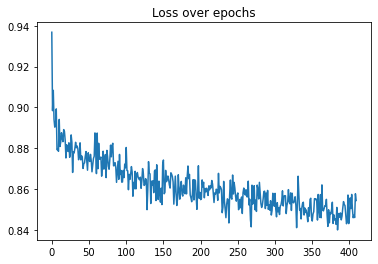

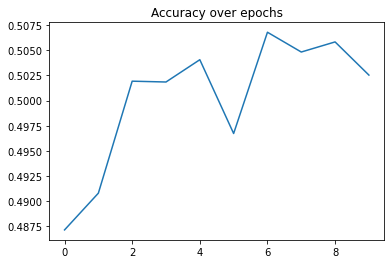

In [23]:
plt.figure(1)
plt.plot(losses_history)
plt.title("Loss over epochs")

plt.figure(2)
plt.plot(val_accs)
plt.title("Accuracy over epochs")

In [24]:
print("Accuracy: %.3f" % accuracy_score(val_labels_last, outs_preds))
print("F1 score: %.3f" % f1_score(val_labels_last, outs_preds, average='weighted'))
# This one reports too high auc...
#auc_score = roc_auc_score(val_labels_last, outs_preds)

# plt.figure(3, figsize=(12,8), dpi=80)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='ROC (area = {:.3f})'.format(auc_score))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

Accuracy: 0.507
F1 score: 0.465


<AxesSubplot:>

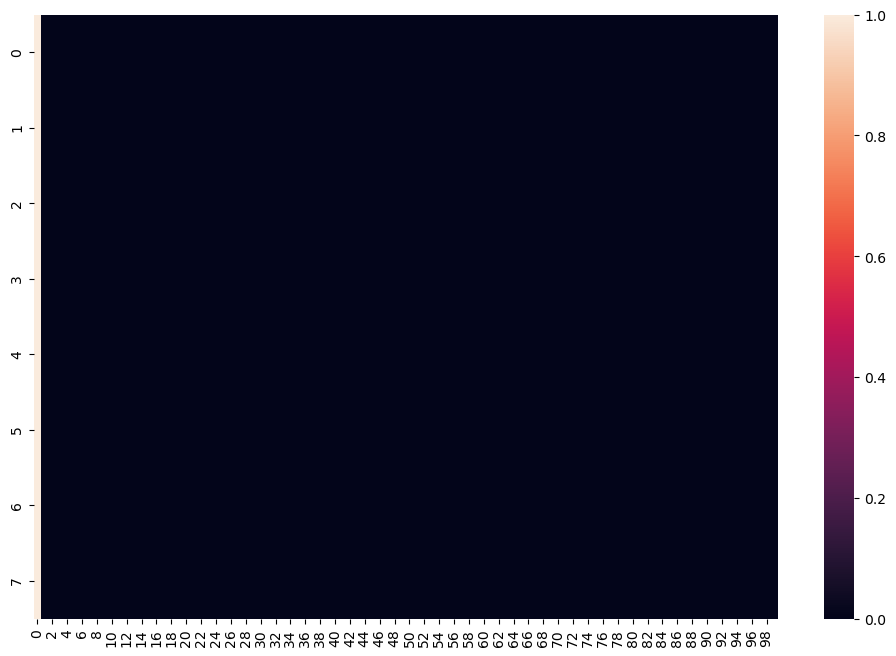

In [25]:
head_idx = 0
batch_idx = 0
# attn = model.encoder[0].multi_en.attn[batch_idx:batch_idx + BATCH_SIZE].squeeze()
attn = model.encoder[0].multi_en.attn[0, :]
plt.figure(2, figsize=(12,8), dpi=100)
seaborn.heatmap(attn[:12,0].cpu().detach().numpy())

In [26]:
idx = 50
with h5py.File(INPUT_PATH,'r') as h5_file:
  exercises_test = torch.from_numpy(h5_file['exercises_test'][idx:idx+1]).long().cuda()
  exercise_ids_test = torch.from_numpy(h5_file['exercise_ids_test'][idx:idx+1]).long().cuda()
  labels_test = h5_file['labels_test'][idx:idx+1]
  shifted_label_test = torch.roll(torch.from_numpy(labels_test), 1).long().cuda()
  shifted_label_test[:,0] = 2  
  elapsed_test = h5_file['elapsed_test'][idx:idx+1]
  timestamp_test = h5_file['timestamps_test'][idx:idx+1]  
  elapsed = torch.from_numpy(elapsed_test).float().cuda().unsqueeze(2)
  timestamp = torch.from_numpy(timestamp_test).float().cuda().unsqueeze(2)

  print(exercise_ids_test.shape)
  print(exercises_test.shape)
  print(shifted_label_test.shape)
  print(elapsed.shape)  
  print(timestamp.shape)

  outs_pred = model(exercise_ids_test, exercises_test, shifted_label_test, elapsed, timestamp)        

  img_width = TIME_STEPS
  max_width = 30

  ground_truth = labels_test.squeeze()
  pred = outs_pred.squeeze().cpu().detach().numpy()

  # Define image
  img = np.ndarray((3, img_width))
  img = img[:, :max_width]

  # Set category color
  ex_color = exercises_test.squeeze().cpu().detach().numpy()
  color_dict = dict(enumerate(list(set(ex_color))))
  color_dict = {v:k for k,v in color_dict.items()}
  colors = list(map(lambda x: (color_dict[x] + 1)/len(color_dict.keys()), ex_color))
  colors = colors[-max_width:]
  img[0,:] = colors

  # Set ground truth color
  ground_truth = ground_truth[-max_width:]
  img[1,:] = ground_truth

  # Set prediction color
  pred = pred[-max_width:]
  img[2,:] = pred

  # Show the figure
  plt.figure(4, figsize=(12,8), dpi=100)
  plt.imshow(img)
  plt.text(max_width, 0.15, "Category")
  plt.text(max_width, 1.15, "Ground truth")
  plt.text(max_width, 2.15, "Prediction")

  # Index
  print("index index: %i" % idx)

torch.Size([1, 100])
torch.Size([1, 100])
torch.Size([1, 100])
torch.Size([1, 100, 1])
torch.Size([1, 100, 1])


ValueError: could not broadcast input array from shape (30,3) into shape (30)